#### Testing relative performance of multiple machine learning models "working together" versus a solo machine learning model. 

#### Experiment to see how multiple neural network models might "collaborate" versus a solo neural network tasked with the same classification challenge. The task for both nets was to classify unseen sections of RBA text.  

#### Labels relate to forward actions by the RBA. Class labels were balanced for each run. Rebalancing the classes resulted in some reduction of variance within the classes of interest. 

#### Results are down the bottom of the notebook. 

#### Three distinct but related sets of text data were passed to three separate neural nets at the same time. Each had distinct and separate text classification tasks but at the same time the two auxiliary models would be allowed to share updates as they trained with the main model. 

#### The three data sets are as follows:  

1. Text from RBA "deemed" neutral.
2. Text from RBA "deemed" dovish.
3. Text from RBA "deemed" hawkish.
                  
#### Machine learning models were set to analyse paragraphs or chunks of text in blocks of around 100 words at a time. LSTM layers were used to remember sequences of 100 words at a time and find any pattern or signal.

#### Oct/2018

In [1]:
import os
import shutil
import time, glob

#Tensorflow
import tensorflow as tf 

#Pandas
import pandas as pd
from pandas import read_csv

#Numpy
import numpy as np
from numpy import array
from array import array
from numpy import argmax
from numpy import zeros

#Randoms
import os
from tqdm import tqdm 
from itertools import cycle
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import string

#Matplotlib  
%matplotlib inline
import matplotlib.pyplot as plt


#SK Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import resample
 
   
#Keras
import keras
from keras.engine import Input
from keras.models import Model
from keras.layers.merge import dot
from keras.utils import plot_model
from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Masking
from keras import regularizers
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout, Input
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM
from keras import optimizers
from keras import regularizers
from keras.layers import Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.utils.np_utils import to_categorical
    
#Print Confusion matrix and F1 score
def print_metrics(self,y):
    pred_round_1 = np.round(self, decimals=0,out=None)
    f1 = f1_score(y, pred_round_1,average='binary')
    con_1= confusion_matrix(y, pred_round_1)
    print(con_1)
    print(f1)
    
    
#Plot convergence path for collaborative model   
def plot_model(self): 
    plt.plot(self.history['main_output_acc'])
    plt.plot(self.history['val_main_output_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()     
    plt.plot(self.history['main_output_loss'])
    plt.plot(self.history['val_main_output_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() 
    
#Plot convergence path for solo model  
def plot_model_solo(self): 
    plt.plot(self.history['acc'])
    plt.plot(self.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()     
    plt.plot(self.history['loss'])
    plt.plot(self.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() 

Using TensorFlow backend.


### Read in text files for various predictor matrices.  Three bodies of text split into "Neutral", "Dovish" and "Hawkish". 

In [2]:
#Read in all files from folder relating to "RBA neutral"  text
with open("RBA_neutral", 'wb',) as outfile:
    for filename in glob.glob( 'RBA_neutral*.csv'):
        if filename == outfile:             
            continue
        with open(filename, 'rb') as readfile:
            shutil.copyfileobj(readfile, outfile)
#Save "RBA neutral" text
x = pd.read_fwf('RBA_neutral ',
                sep=".",encoding='utf8',usecols=[0], header=None)
x.rename(columns={0:'text'},inplace=True)


             
#Open and read in all files relating to "RBA dovish" text
with open("RBA_dovish", 'wb',) as outfile:
    for filename in glob.glob('RBA_dovish*.csv',):
        if filename == outfile:            
            continue
        with open(filename, 'rb') as readfile:
            shutil.copyfileobj(readfile, outfile) 
#Save "RBA dovish" text
x1 = pd.read_fwf('RBA_dovish',sep=".",encoding='utf8',
                 usecols=[0], header=None)
x1.rename(columns={0:'text'},inplace=True) 


#Read in all files relating to "RBA hawkish" text 
with open("RBA_hawkish", 'wb',) as outfile:
    for filename in glob.glob('RBA_hawkish*.csv',):
        if filename == outfile:             
            continue
        with open(filename, 'rb') as readfile:
            shutil.copyfileobj(readfile, outfile) 
#Save "RBA hawkish" text
x2 = pd.read_fwf('RBA_hawkish.csv',sep=".",
                encoding='utf8',usecols=[0], header=None)
x2.rename(columns={0:'text'},inplace=True)
 
 

print(x.shape,x1.shape,x2.shape)

((3984, 1), (923, 1), (529, 1))


### Define binary class labels for each neural net.

In [3]:
#Define DF for text enocoding below. 
result= pd.concat([x,x1,x2])
#Set target class label array for each Neural Net
labels_zeros = np.zeros(400,)
labels_ones = np.ones(400,)

print(result.shape, labels_zeros.shape,labels_ones.shape)

((5436, 1), (400,), (400,))


### Tokenize, encode and pad. No NLP preprocessing performed(eg, no punctuation or stopwords removed, no Stemming or Lemmatizing).

In [4]:
#Using one Tokinizer to fit on entire text from three files to allow for widest vocabulary index.

#Encode blocks of 10 tokens at a time.
max_length = 10

t_1 = Tokenizer()
docs_1= result['text']
#Neutral
docs_2 = x['text']
#Dovish
docs_3 = x1['text']
#Hawkish
docs_4 = x2['text']
 


#Used the following Tokenizer to help encode all three predictor arrays for each Neural Network.
#Each word and punctuation is assigned a unique integer. From there each word is effectively
#assigned a 200 dimension word embedding vector. Each dimension represents a conversational context.
#Number of contexts is decided upfront depending on the size and complexity of the target corpus. 

t_1.fit_on_texts(docs_1)
vocab_size_1 = len(t_1.word_index) + 1

#Neutral
encoded_docs_1 = t_1.texts_to_sequences(docs_2)
#Dovish
encoded_docs_2 = t_1.texts_to_sequences(docs_3)
#Hawkish
encoded_docs_3 = t_1.texts_to_sequences(docs_4)
 


#Neutral
padded_docs_1 = pad_sequences(encoded_docs_1, maxlen=max_length, padding='post')
#Dovish
padded_docs_2 = pad_sequences(encoded_docs_2, maxlen=max_length, padding='post')
#Hawkish
padded_docs_3 = pad_sequences(encoded_docs_3, maxlen=max_length, padding='post')
 

print(vocab_size_1,padded_docs_1.shape,padded_docs_2.shape,padded_docs_3.shape) 

(2298, (3984, 10), (923, 10), (529, 10))


In [5]:
#Subjectively decided to round up using top of text files as the top and bottom of corpus
#tends to have important content.
 
#Rounding up before reshaping
#RBA neutral text enlarged
padded_docs_4= padded_docs_1[0:16]
padded_docs_5 = np.concatenate((padded_docs_1,padded_docs_4),axis=0)
 

#Rounding up before reshaping
#RBA dovish text enlarged
padded_docs_6= padded_docs_2[0:77]
padded_docs_7 = np.concatenate((padded_docs_2,padded_docs_6),axis=0)
 

#Rounding up before reshaping
#RBA hawkish text enlarged
padded_docs_8= padded_docs_3[0:71]
padded_docs_9 = np.concatenate((padded_docs_3,padded_docs_8),axis=0)
print(padded_docs_5.shape,padded_docs_7.shape,padded_docs_9.shape)

(4000, 10)
(1000, 10)
(600, 10)


In [6]:
#Reshape encoded docs for lstm layer to remember sequence of 100 word blocks at a
#time versus each class label.

#RBA neutral text
padded_docs_5= padded_docs_5.reshape(400,100)
#RBA dovish text
padded_docs_7= padded_docs_7.reshape(100,100)
#RBA hawkish text
padded_docs_9= padded_docs_9.reshape(60,100)
 

print(padded_docs_5.shape,padded_docs_7.shape,padded_docs_9.shape)

((400, 100), (100, 100), (60, 100))


In [7]:
#Upsample with replacement to rebalance other classes to size of the largest class.

#Upsample dovish text
padded_docs_2_up = resample(padded_docs_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=123) # reproducible results
 
#Upsample hawkish text
padded_docs_3_up = resample(padded_docs_9, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=123) # reproducible results
 

print(padded_docs_2_up.shape,padded_docs_3_up.shape)

((400, 100), (400, 100))


In [8]:
#Create four predictor arrays and define labels.
labels = np.concatenate((labels_zeros,labels_ones),axis=0)
#Assert label array shape
labels.shape=(800,1)

#Neutral or dovish predictor array.
ne = np.concatenate((padded_docs_5,padded_docs_2_up),axis=0)

#Neutral or hawkish predictor array.
nh = np.concatenate((padded_docs_5,padded_docs_3_up),axis=0)
  
#Dovish or hawkish predictor array.
eh = np.concatenate((padded_docs_2_up,padded_docs_3_up),axis=0)

 

print(ne.shape,nh.shape,eh.shape)

((800, 100), (800, 100), (800, 100))


In [9]:
#Split arrays into train/test(80/20) for each neural network. Seeded split.
X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(nh,labels,test_size=0.20, shuffle=True,random_state=42)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(eh,labels, test_size=0.20, shuffle=True,random_state=42)
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(ne,labels, test_size=0.20, shuffle=True,random_state=42)

In [10]:
#Collaborative net. Each net is training on its own text file and looking for specific 
#patterns in their own right. However the idea behind the test is to see if sharing what each
#model is learning via the LSTM layers will collectively help the main model.  


#First auxiliary model..feeding it "Dovish or hawkish" text and associated labels.
auxiliary_input_1 = Input(shape=(100,)) 
e_2 = Embedding(vocab_size_1,200, input_length=100,trainable=True)(auxiliary_input_1)
lstm_2 = LSTM(200,input_shape=(100,1))(e_2)
#Logistic regression layer
auxiliary_output_1 = Dense(1, activation='sigmoid', name='aux_output_1')(lstm_2)  

          
#Second auxiliary model..feeding it "Neutral or Dovish" text and associated labels. 
auxiliary_input_2 = Input(shape=(100,)) 
e_3 = Embedding(vocab_size_1,200, input_length=100,trainable=True)(auxiliary_input_2)
lstm_3 = LSTM(200,input_shape=(100,1))(e_3)
#Logistic regression layer
auxiliary_output_2 = Dense(1, activation='sigmoid', name='aux_output_2')(lstm_3) 


#Main model...feeding it "Neutral or hawkish" text and associated labels.
main_input = Input(shape=(100, ), name='aux_input')
e_1 = Embedding(vocab_size_1, 200,input_length=100,trainable=True)(main_input)
lstm_1 = LSTM(200,input_shape=(100,1))(e_1) 
#Merge LSTM layers
x = keras.layers.concatenate([lstm_1,lstm_2,lstm_3])  
#logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)    
         
#Define inputs and outputs from main model. 
model = Model(inputs=[main_input, auxiliary_input_1,auxiliary_input_2], outputs=[main_output, auxiliary_output_1,auxiliary_output_2])


#Allowing for equal loss contributions from each model.  
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'],loss_weights=[1.0,1.0,1.0]) 
 

history_1 = model.fit([X_train_1, X_train_2, X_train_3], [y_train_1, y_train_2, y_train_3],
         batch_size=10, epochs=50,
           validation_split=0.10, shuffle=True, verbose=1) 


model.evaluate([X_test_1, X_test_2, X_test_3], [y_test_1, y_test_2, y_test_3], batch_size=10)


collab_mod = model.predict([X_test_1, X_test_2, X_test_3], batch_size=10,verbose=2) 

Train on 576 samples, validate on 64 samples
Epoch 1/50
576/576 [==============================] - 16s 28ms/step - loss: 2.0548 - main_output_loss: 0.6763 - aux_output_1_loss: 0.6741 - aux_output_2_loss: 0.7044 - main_output_acc: 0.6545 - aux_output_1_acc: 0.7205 - aux_output_2_acc: 0.6267 - val_loss: 1.8194 - val_main_output_loss: 0.5890 - val_aux_output_1_loss: 0.6443 - val_aux_output_2_loss: 0.5861 - val_main_output_acc: 0.8437 - val_aux_output_1_acc: 0.7500 - val_aux_output_2_acc: 0.8438
Epoch 2/50
576/576 [==============================] - 13s 23ms/step - loss: 1.0476 - main_output_loss: 0.2649 - aux_output_1_loss: 0.3050 - aux_output_2_loss: 0.4778 - main_output_acc: 0.9097 - aux_output_1_acc: 0.9045 - aux_output_2_acc: 0.7986 - val_loss: 0.5770 - val_main_output_loss: 0.0774 - val_aux_output_1_loss: 0.0949 - val_aux_output_2_loss: 0.4047 - val_main_output_acc: 0.9844 - val_aux_output_1_acc: 0.9687 - val_aux_output_2_acc: 0.8437
Epoch 3/50
576/576 [==============================]

Epoch 19/50
576/576 [==============================] - 16s 28ms/step - loss: 0.0117 - main_output_loss: 1.2130e-05 - aux_output_1_loss: 2.5643e-07 - aux_output_2_loss: 0.0117 - main_output_acc: 1.0000 - aux_output_1_acc: 1.0000 - aux_output_2_acc: 0.9965 - val_loss: 0.5064 - val_main_output_loss: 0.0018 - val_aux_output_1_loss: 0.0531 - val_aux_output_2_loss: 0.4515 - val_main_output_acc: 1.0000 - val_aux_output_1_acc: 0.9844 - val_aux_output_2_acc: 0.9375
Epoch 20/50
576/576 [==============================] - 16s 28ms/step - loss: 8.4440e-05 - main_output_loss: 1.5787e-07 - aux_output_1_loss: 1.6334e-07 - aux_output_2_loss: 8.4119e-05 - main_output_acc: 1.0000 - aux_output_1_acc: 1.0000 - aux_output_2_acc: 1.0000 - val_loss: 0.6451 - val_main_output_loss: 9.0918e-04 - val_aux_output_1_loss: 0.0538 - val_aux_output_2_loss: 0.5904 - val_main_output_acc: 1.0000 - val_aux_output_1_acc: 0.9844 - val_aux_output_2_acc: 0.9375
Epoch 21/50
576/576 [==============================] - 16s 28ms/st

In [11]:
#Check metrics for collaborative net
model.metrics_names 

['loss',
 'main_output_loss',
 'aux_output_1_loss',
 'aux_output_2_loss',
 'main_output_acc',
 'aux_output_1_acc',
 'aux_output_2_acc']

In [12]:
#Precision/recall check & f1 score for collaborative model
print_metrics(collab_mod[0],y_test_1)

[[80  0]
 [ 0 80]]
1.0


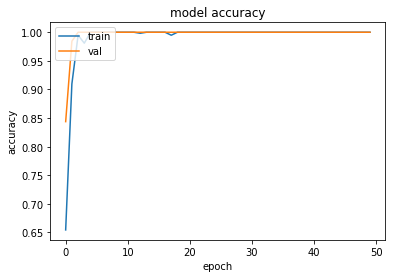

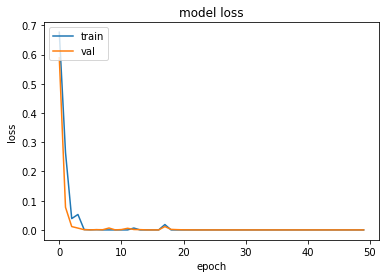

In [13]:
#Plot collaborative model behaviour over 50 epochs
plot_model(history_1)

In [14]:
#Solo model,using sequential model. Model is asked to predict if unseen text is neutral
#or hawkish.

model_2 = Sequential()


#Add embedding layer, allow for layer to retrain
e = Embedding(vocab_size_1, 200, input_length=100, trainable=True)
model_2.add(e)

#LSTM layer
model_2.add(LSTM(200, input_shape=(100,1)))
#Logistic Regression classifier layer
model_2.add(Dense(1, activation='sigmoid'))

#Compile model, same loss function and optimizer as main model from the collaborative net above
model_2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
 
#Fit the model
history_2 = model_2.fit(X_train_1, y_train_1, shuffle=True, batch_size=10, epochs=50, 
           validation_split=0.10,verbose=1)

#Evaluate the model
model_2.evaluate(X_test_1,y_test_1, verbose=2,batch_size=10)

pred_ldense = model_2.predict(X_test_1, batch_size=10,verbose=2)

Train on 576 samples, validate on 64 samples
Epoch 1/50
576/576 [==============================] - 10s 17ms/step - loss: 0.9521 - acc: 0.5243 - val_loss: 0.6698 - val_acc: 0.6875
Epoch 2/50
576/576 [==============================] - 8s 15ms/step - loss: 0.6165 - acc: 0.7187 - val_loss: 0.5507 - val_acc: 0.8281
Epoch 3/50
576/576 [==============================] - 9s 15ms/step - loss: 0.2733 - acc: 0.9097 - val_loss: 0.1305 - val_acc: 0.9531
Epoch 4/50
576/576 [==============================] - 9s 15ms/step - loss: 0.0550 - acc: 0.9896 - val_loss: 0.1255 - val_acc: 0.9531
Epoch 5/50
576/576 [==============================] - 9s 15ms/step - loss: 0.0183 - acc: 0.9983 - val_loss: 0.0743 - val_acc: 0.9687
Epoch 6/50
576/576 [==============================] - 9s 16ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0733 - val_acc: 0.9844
Epoch 7/50
576/576 [==============================] - 9s 15ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0719 - val_acc: 0.9844
Epoch 8/50
576/576 [===

In [15]:
#Confusion matrix and F1 score for solo model.
print_metrics(pred_ldense,y_test_1)

[[75  5]
 [ 0 80]]
0.9696969696969697


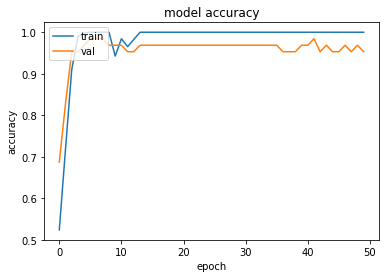

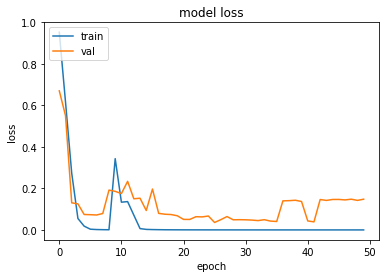

In [16]:
#Plot model path over 50 epochs.  
plot_model_solo(history_2)